# Assignment  week 5 MRS Chap 21

## Notebook made by   (If not filled in correctly: 0 pts for assignment)

__Name(s)__: Adriaan de Vries, Verna Dankers

__Student id(s)__ : 10795227, 10761225

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. **Assignments without the selfies will not be graded and receive 0 points.**

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img width=30% src='http://oi63.tinypic.com/2q3srh3.jpg'/>
<img width=30% src="http://i63.tinypic.com/2itj1ic.jpg" border="0">

# Link Analysis



#### Q1 Hits
1. Create the network consisting of the page <http://en.wikipedia.org/wiki/PageRank>, all pages that link to that page (you get those via <http://en.wikipedia.org/wiki/Special:WhatLinksHere/PageRank>), and all outgoing links from <http://en.wikipedia.org/wiki/PageRank>. 

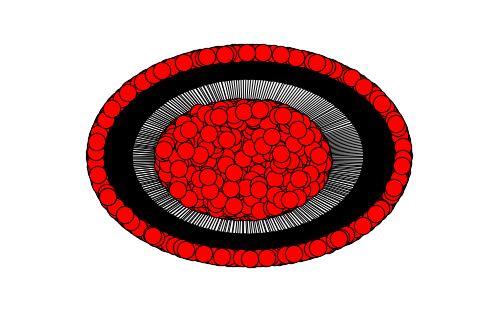

In [2]:
%matplotlib inline

import networkx as nx
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
START_NODE = 'PAGERANKSTARTNODE' 

G = nx.DiGraph()
G.add_node(START_NODE)

# path leads to file with all links to PageRank
f = open('.\Pagerank\outlinks.htm', 'rb')
text = f.read().decode('utf8', 'ignore')
soup = BeautifulSoup(text)
for elem in soup.find_all('li'):
    try:
        link = elem.a.get('href')
        G.add_node(link)
        G.add_edge(link, START_NODE)
    except Exception: 
        pass

# path leads to file with PageRank
f = open('.\Pagerank\PageRank.htm', 'rb')
text = f.read().decode('utf8', 'ignore')
soup = BeautifulSoup(text)
for elem in soup.find_all('a'):
    try:
        link = elem.get('href')
        if link[:4] == 'http':
            G.add_node(link)
            G.add_edge(START_NODE, link)
    except Exception: 
        pass
nx.draw(G)
plt.show()

2. ~~Compute the HITS score for each node in this network.~~
3.   Use the `networkx` package to display the network nicely.

#### Q2 Pagerank and hits

* Do questions Q5,Q6,Q9,Q10 from <http://nbviewer.ipython.org/url/maartenmarx.nl/teaching/zoekmachines/Assignments/ASSIGNMENTS/Week7InformationRetrieval.ipynb>

### Q5

The PageRank algorithm

In [47]:
def PageRank_step(PageDict, G):
    """
    Update the pageranks at one iteration.
    """
    d = 0.85
    N = len(PageDict)
    newPageDict = {}
    for p_i in PageDict:
        summation = 0
        for p_j in G.predecessors(p_i):
            summation += PageDict[p_j] / len(G.successors(p_j))
        newPageDict[p_i] = (1-d)/N + d * summation
    return newPageDict
        
def my_pagerank(G,iterations=20):
    """
    Given a graph of links, calculate het
    pagerank iteratively.
    """
    # preparation
    PageDict = {}
    nodes = G.nodes()
    length = len(nodes)
    starting_value = 1/length
    for node in nodes:
        PageDict[node] = starting_value
    
    # actual  pagerank
    for i in range(iterations):
        PageDict = PageRank_step(PageDict, G)
        
    # finally normalize
    valuesum = sum(PageDict.values())
    factor = 1/valuesum
    for key in PageDict:
        PageDict[key] *= factor 
    # and return
    return PageDict

In [48]:
my_PR = my_pagerank(G)
nx_PR = nx.pagerank(G)
print('my unique values: ', sorted(set(my_PR.values())))
print('nx unique values: ', sorted(set(nx_PR.values())))
print('my sum: ', sum(my_PR.values()))

print('nx sum: ', sum(nx_PR.values()))

my unique values:  [0.000187072268429871, 0.0006331921601418626, 0.35887219996896197]
nx unique values:  [0.00018722550504969487, 0.0006327437470279013, 0.35900851541765433]
my sum:  1.0000000000000049
nx sum:  0.9999999999999986


### Q6

Comparing the unique values shows that the two implmentations are very close, and probably only differ in their handling of rounding. For example, our version sums to ever so slightly more than 1, and the nx version to slightly less than 1.

It's clear from the above results that the maximum squared error is the squared error of the PageRank of the PageRank page itself. That, and the mean of squared errors, is calculated in the cell below.

In [49]:
MSE = 0
for key in my_PR:
    MSE += (my_PR[key] - nx_PR[key]) **2
MSE /= len(my_PR)
print ('Mean Squared Error: ' , MSE)
print ('Maximum Squared Error: ', (my_PR[START_NODE] - nx_PR[START_NODE])**2)

Mean Squared Error:  1.0431579172491579e-11
Maximum Squared Error:  1.858190155219916e-08


Finally, we will note the effect of using more iterations for our algorithm. To do this, we calculate the Mean and Maximum Squared Error between our algorithm ran with 20 iterations, and with 100 iterations.

In [51]:
my_PR20 = my_pagerank(G, iterations=20)
my_PR100 = my_pagerank(G, iterations=100)

MSE = 0
for key in my_PR20:
    MSE += (my_PR20[key] - my_PR100[key]) **2
MSE /= len(my_PR20)
print ('Mean Squared Error: ' , MSE)
print ('Maximum Squared Error: ', (my_PR20[START_NODE] - my_PR100[START_NODE])**2)

Mean Squared Error:  9.659340047500845e-13
Maximum Squared Error:  1.7304756057773132e-09


Again, the error is so small that we can conclude the algorithm converged farily well within 20 iterations.

### Q9

HITS algorithm

In [67]:
import math

# Using a dict with nodes as keys and values being dicts containing the hub and auth scores.

def dict_norm(dictionary, hub_or_auth):
    return   math.sqrt(sum(dictionary[key][hub_or_auth]**2 for key in dictionary))

def hits_step(G, hits_dict):
    """
    Recalculate the hits at one iteration.
    """
    #make new dict (needed for parallel updating)
    new_dict = {}
    
    # fill the new dict with new values
    for key in hits_dict:
        hubsum = 0
        authsum = 0
        for node in G.predecessors(key):
            hubsum += hits_dict[node]['hub']
        for node in G.successors(key):
            authsum += hits_dict[node]['auth']
        new_dict[key] = {}
        new_dict[key]['auth'] = hubsum
        new_dict[key]['hub'] = authsum
        
    #normalize
    hub_norm = dict_norm(new_dict, 'hub')
    auth_norm = dict_norm(new_dict, 'auth')
    for key in new_dict:
        new_dict[key]['hub'] /= hub_norm
        new_dict[key]['auth'] /= auth_norm
    return new_dict

def hits(G,iterations=40):
    """
    Calculate the hits for a given network,
    for a given number of iterations.
    """
    # initialize
    hits_dict = {}
    for node in G.nodes():
        hits_dict[node] = {}
        hits_dict[node]['hub'] = 1
        hits_dict[node]['auth'] = 1

    # iterate
    for _ in  range(iterations):
        hits_dict = hits_step(G, hits_dict)

    # seperate auth and hub
    
    hub_dict = {}
    auth_dict = {}
    for key in hits_dict:
        hub_dict[key] = hits_dict[key]['hub']
        auth_dict[key] = hits_dict[key]['auth']    
    return hub_dict, auth_dict

# test
hub_dict, auth_dict = hits(G, iterations = 100)
print(set(hub_dict.values()))
print(set(auth_dict.values()))

{0.02626128657194451, 0.0, 1.8338581573920071e-165}
{0.0, 6.983123817521499e-164, 1.0}


### Q10

In [73]:
hub_dict, auth_dict = hits(G, iterations = 100)
nx_hubs, nx_auth = nx.hits(G)
print(sorted(set(hub_dict.values())))
print(sorted(set(nx_hubs.values())))
print(sorted(set(auth_dict.values())))
print(sorted(set(nx_auth.values())))



[0.0, 1.2697580450122795e-18, 0.02626128657194451]
[0.0, 4.795506509999171e-12, 0.0006896551724104858]
[0.0, 4.835094585080179e-17, 1.0]
[0.0, 1.0165912852604216e-11, 0.999999993046521]


As you can see from the results, the networkx implementation and ours give the same results. The auth scores converge to the point where PageRank has 1, and all others have 0. The hub score converges to the point that the total hub score is divided among the pages that link to PageRank, and all others have 0.

The difference in hub scores between our implementation and the networkx implementation comes from the fact that we normalize the scores by dividing all the scores by the euclidean norm (so the square root of the sum of squares), where networkx simply divides by the sum. So if there are N pages that link to PageRank, the hub scores of those pages will be $\frac{1}{N}$ for the networkx implementation, and $\frac{1}{\sqrt{N}}$ for our implementation.

# Make inverted index

[MakeInvertedIndex](MakeInvertedIndex1516.html): 11  

#### 1 Choose three zones and indicate why these are good and interesting for this data set. Also give weights for each of them. 

- <b>trefwoordlod</b>: this is a good zone to look at, since it indicates the keywords from the file. Users often put such keywords in their queries. If they query terms are inside of these zone, this file is definitely a hit! <b>Weight: 0.45</b>

- <b>citeertitel</b>: this is a good zone to look at, since it summarizes the content of the file in one sentence. If this zone contains a query term, this file is very likely to be a hit! <b>Weight: 0.3</b>

- <b>tekstxml</b>: this is a good zone to look at because this is the body of the file that contains the actual text of the motion. If this zone does not contain a query term or a synonym of a query term, the file is not relevant. <b>Weight: 0.25</b>

#### 2 You want to use TF-IDF weighting for the scoring function of each zone. Think whether you must adjust IDF as well for each zone, or you can just use IDF as before? Argue why your answer is good, possibly using an instructive example.

The original defitions:

$tfidf_{t,d} = tf_{t,d} \cdot idf_{t}$

$idf_{t} = \log(\frac{N}{df_{t}})$ where $N$ is the number of documents in the collection.

When using $tfidf$-weighting for the scoring function of each zone, the $idf$ formula must be adjusted. Why? Let's consider an example. 
Suppose the word ASIELZOEKERSCENTRA only appears in one 'trefwoordlod' in your entire corpus. When your query term contains ASIELZOEKERSCENTRA, that file is a hit! The fact that the word is in the 'trefwoordlod' zone is very important, since that zone is an important zone, since it contains the keywords from the file. But if ASIELZOEKERSCENTRA appears in many documents inside the 'tekstxml' zone, the idf weight for ASIELZOEKERSCENTRA in the 'trefwoordlod' zone will still be very very low. We do not want that, because the fact that ASIELZOEKERSCENTRA is in the 'trefwoordlod' zone still really distinguishes that file from all of the other files, when looking at the 'trefwoordlod' zone. So we want the idf weight for ASIELZOEKERSCENTRA in the 'trefwoordlod' to be high. Therefore it is a better idea to consider only the 'trefwoordlod' zone frequency when calculating that idf weight for that zone. So we would adapt the $idf$ formula:

$idf_{t,z} = \log(\frac{N}{df_{t,z}})$ where $z$ indicates which zone to look at. So we do not use the regular document frequency, but the frequency of term t in all zones $z$.

#### 3 Design an index for your 3 zones and an algorithm which computes score(q,d) based on the linear weighted scoring function from MRS 6.1. Implement it on top of your earlier code. 

Since the exercise did not state whether this index should be a positional index, we did not make it a positional index.

In [13]:
from earlier_code import normalize
from bs4 import BeautifulSoup
from nltk.tokenize import WhitespaceTokenizer
from collections import Counter, defaultdict
import os

def zone_index(folder, zones, keep_capitals):
    """
    Create an inverted index given a folder 
    containig a text corpus.
    """
    index = defaultdict() # initialize MyIndex

    # Prepare each file one by one
    for filename in os.listdir(folder):
        if filename[-3:] == 'xml':
            xmlfile = BeautifulSoup(open(os.path.join(folder, filename), 'rb'),"xml")

            for zone in zones:
                zone_text = xmlfile.find(zone).get_text()

                # Split the text on whitespaces
                zone_text = WhitespaceTokenizer().tokenize(zone_text)

                # Normalize text for capital letters, non-alphabetical tokens and whitespace
                # normalize() is from earlier code, and can be found in attached .py file
                text = [ normalize(word, keep_capitals)
                         for word 
                         in zone_text
                        ]

                # Update the index with each token
                for w in text:    
                    if not w in index:
                        index[w] = defaultdict(Counter)
                    index[w][filename[:-4]][zone]+=1 
    
    if '' in index.keys():
        del index['']
    return index

In [14]:
CORPUS = "Moties/XML/MOT"

index = zone_index(CORPUS,['trefwoordlod','tekstxml','citeertitel'], 0)

# Small test to show what the index looks like
print(index['palestijnse'])

defaultdict(<class 'collections.Counter'>, {'2016830': Counter({'trefwoordlod': 1}), '1950979': Counter({'tekstxml': 2}), '1955666': Counter({'tekstxml': 1}), '1950824': Counter({'citeertitel': 1, 'tekstxml': 1}), '2049338': Counter({'tekstxml': 2}), '2044294': Counter({'tekstxml': 1}), '1808035': Counter({'tekstxml': 2}), '6001979': Counter({'tekstxml': 3, 'citeertitel': 1, 'trefwoordlod': 1}), '5579982': Counter({'tekstxml': 2, 'citeertitel': 1, 'trefwoordlod': 1}), '1965629': Counter({'tekstxml': 1}), '6001967': Counter({'tekstxml': 4, 'citeertitel': 1, 'trefwoordlod': 1}), '6001962': Counter({'tekstxml': 3, 'citeertitel': 1, 'trefwoordlod': 1}), '2017478': Counter({'tekstxml': 3, 'trefwoordlod': 1}), '1987335': Counter({'citeertitel': 1, 'tekstxml': 1}), '2021008': Counter({'tekstxml': 4, 'citeertitel': 1, 'trefwoordlod': 1}), '1950926': Counter({'citeertitel': 1, 'tekstxml': 1}), '2043794': Counter({'tekstxml': 1}), '2016817': Counter({'tekstxml': 3, 'trefwoordlod': 1}), '1802274'

In [15]:
def add_frequencies(index):
    """
    Add the document and corpus frequency per zone to a 
    word in an inverted index.
    """
    for word in index:
        original_counter = index[word]
        # ugly because not every 'field' exists
        tekst_doc_freq = 0
        titel_doc_freq = 0
        trefwoord_doc_freq = 0
        tekst_corp_freq = 0
        titel_corp_freq = 0
        trefwoord_corp_freq = 0
        for key in index[word]:
            if 'tekstxml' in index[word][key]:
                tekst_doc_freq +=1
                tekst_corp_freq += index[word][key]['tekstxml']
            if 'citeertitel' in index[word][key]:
                titel_doc_freq +=1
                titel_corp_freq += index[word][key]['citeertitel']
            if 'trefwoordlod' in index[word][key]:
                trefwoord_doc_freq +=1
                trefwoord_corp_freq += index[word][key]['trefwoordlod']
        document_frequency = {'tekstxml':tekst_doc_freq, 'citeertitel':titel_doc_freq, 'trefwoordlod':trefwoord_doc_freq}
        corpus_frequency = {'tekstxml':tekst_corp_freq, 'citeertitel':titel_corp_freq, 'trefwoordlod':trefwoord_corp_freq}
        index[word] = {"counter" : original_counter, 
                       "doc_freq" : document_frequency, 
                       "corp_freq" : corpus_frequency
                      }
    return index

In [16]:
index_with_freq = add_frequencies(index)

# Small test to show that it works
print(index_with_freq['palestijnse']['corp_freq'])
print(index_with_freq['palestijnse']['doc_freq'])

{'citeertitel': 12, 'tekstxml': 75, 'trefwoordlod': 16}
{'citeertitel': 12, 'tekstxml': 41, 'trefwoordlod': 16}


In [17]:
# S set of all docs is useful for all sorts of things. 
# Its cardinality, for example, is a term in IDF.

doc_set = []
for term in index_with_freq:
    for doc in index_with_freq[term]['counter']:
        doc_set.append(doc)
doc_set = set(doc_set)
print (len(doc_set))

27944


In [28]:
from math import log

def tf_idf_zone_score(query, doc, index):
    """
    Per assignment 11.3, calculates the weighted zone score
    for a given query and document using TF-IDF
    """
    # Weights for zones, should sum to 1
    trefwoordlod_weight = 0.45
    citeertitel_weight = 0.3
    tekstxml_weight = 0.25
    
    score = 0
    for term in query:
        # Score remains the same if the query term does not appear in the document
        if (term in index) and (doc in index[term]['counter']):
            N = len(doc_set)
            if 'trefwoordlod' in index[term]['counter'][doc]:
                trefwoord_IDF = log(N / index[term]['doc_freq']['trefwoordlod'])
                score += trefwoord_IDF * trefwoordlod_weight * index[term]['counter'][doc]['trefwoordlod']
            if 'citeertitel' in index[term]['counter'][doc]:
                titel_IDF = log(N / index[term]['doc_freq']['citeertitel'])
                score += titel_IDF * citeertitel_weight * index[term]['counter'][doc]['citeertitel']
            if 'tekstxml' in index[term]['counter'][doc]:
                tekst_IDF = log(N / index[term]['doc_freq']['tekstxml'])
                score += tekst_IDF * tekstxml_weight * index[term]['counter'][doc]['tekstxml']
        
    return score

In [29]:
# Small test to show that it works
print(tf_idf_zone_score(['palestijnse', 'gebied', 'fwqicywqwycv'], '6001971', index_with_freq))
print(tf_idf_zone_score(['de', 'het', 'adviseert', 'kamer'], '6001971', index_with_freq))

13.8395695567
0.207944154168


# MySQL assignment


### Mysql
- Go to http://www.apachefriends.org/en/xampp.html, choose your OS, downloand XAMPP, and follow the instructions.
- Or work from inside your IPython notebook.
    
### Get familiar with full text search in MYSQL.
- <a href='http://devzone.zend.com/26/using-mysql-full-text-searching/'>step by step tutorial</a>
- <a href='http://dev.mysql.com/doc/refman/5.0/en/fulltext-search.html'>The MySQL manual on Full Text searching.</a>

### Try it yourself

- Open PHPMyadmin. Go to the mysql database. Choose the table 'help_topic' from the menu on the left. Now you see the contents of this table. Open the SQL tab and ask a query: e.g. give me all topics about 'minimum'

- Ask this query using the familiar <em>where description LIKE '%minimum%'</em> construction. Notice the time.

> SELECT * FROM `help_topic` WHERE description LIKE '%minimum%', Query took 0.0032 seconds 

- Now ask it using <em>MATCH description AGAINST ('mimimum')</em>, as described in the tutorial.

- Now I got an error. It said that there was no FULLTEXT index on the description field.

- Thus add it. In PHPMyadmin, choose the structure tab. Here you can do many things to your table. Make sure that the type of the description field is of TEXT. Now add  a FULLTEXT index to the description field using the last button on the right (with the T in it). 

- Now ask your MATCH query again. Note the time.

> SELECT * FROM `help_topic` WHERE MATCH description AGAINST('minimum'), Query took 0.0009 seconds

- Now ask for all helptopics with "the" in the description. First old-fashioned with LIKE. Then modern with MATCH. What's going on? The MySQL manual on full text search explains it (and the comments complain about it).

> The difference in run time is pretty small. According to the comments at the MySQL manual the full-text search is slow when there are a lot of rows in the table.

> SELECT * FROM `help_topic` WHERE description LIKE '%the%', Query took 0.0004 seconds

> SELECT * FROM `help_topic` WHERE MATCH description AGAINST('the'), Query took 0.0003 seconds

### Play time: Your first search engine
This is really a MySQL exercise. So you should be able to do this. Refresh your MySQL skills and get help if needed.
- Make a   TABLE named MyWebCollection with fields <em>URL, TITLE, BODY</em>. Put a full text index on body.</li>
- Download a number of webpages (a lot maybe). If you want to stay on familiar ground, download all files from <a href="http://www.cafeconleche.org/examples/shakespeare/">http://www.cafeconleche.org/examples/shakespeare/</a>. For each page,   extract the URL and title, and the complete text of the page (just strip of all HTML). 
- Make a script which creates a text file with MYSQL insert statements that creates a row for each webpage in your table MyWebCollection.
- Now import these rows in your table (you can do this in PHPMyadmin using the import tab).
- Create full text search queries.
- Create a simple web user interface using the PHP example code from the tutorial. For each hit, display the title with a link to the real webpage and the score.

> The code below implements what is described above. BUT the sql insert statements were not executed all together, because our laptops couldn't handle that due to memory issues. They had to be executed one by one to make it work.

In [32]:
from bs4 import BeautifulSoup
import mysql.connector
import urllib

# Start connection to database
db = mysql.connector.connect(host='localhost',database='mysql',user='root',password='')
cursor = db.cursor()

# Create new table
cursor.execute("CREATE TABLE MyWebCollection (url TEXT, title TEXT, body LONGTEXT)")
cursor.execute("ALTER TABLE MyWebCollection ADD FULLTEXT(body)")

In [3]:
SCRAPING_SITE = 'http://www.cafeconleche.org/examples/shakespeare/'

def add_links(website):
    """
    Insert all files from the given website into
    the database.
    """
    text_website = urllib.urlopen(website).read()
    soup_website = BeautifulSoup(text_website, "lxml")
    data = []
    
    # Add all files to the database
    for elem in soup_website.find_all('li'):
        link = elem.a.get('href')
        text_file = urllib.urlopen(website + link).read()
        soup_file = BeautifulSoup(text_file, "xml")
        
        # Values for the three fields
        url = str(website + link)
        title = str(soup_file.TITLE.string)
        body = str(soup_file.text)
        
        data.append((url, title, body))
        
    return data
        

data = add_links(SCRAPING_SITE)
query = "INSERT INTO MyWebCollection(url, title, body) VALUES(%s,%s,%s)"

# Insert into database one by one
for row in data:
    cursor.execute(query, row)
    db.commit()

#### Here are two example full text queries, with the result shown below.

In [104]:
cursor.execute("SELECT title FROM MyWebCollection WHERE MATCH body AGAINST('Othello')")
result = cursor.fetchall()
print(result)

cursor.execute("SELECT title FROM MyWebCollection WHERE MATCH body AGAINST('night')")
result = cursor.fetchall()
print(result)

[(u'The Tragedy of Othello, the Moor of Venice',)]
[(u'The Tragedy of Romeo and Juliet',), (u'The Tragedy of Othello, the Moor of Venice',), (u"A Midsummer Night's Dream",), (u'The Tragedy of Hamlet, Prince of Denmark',), (u'The Tragedy of Julius Caesar',), (u'The Tragedy of King Lear',), (u'The Tragedy of Macbeth',), (u'Much Ado about Nothing',), (u'The Merchant of Venice',), (u'The History of Troilus and Cressida',), (u'The Tragedy of Antony and Cleopatra',), (u'The Tragedy of Richard the Third',), (u'The First Part of Henry the Fourth',), (u'The Second Part of Henry the Fourth',), (u"All's Well That Ends Well",), (u'The Life of Henry the Fifth',), (u'The Life and Death of King John',), (u'The Second Part of Henry the Sixth',), (u'Cymbeline',), (u'The Merry Wives of Windsor',), (u'Pericles, Prince of Tyre',), (u'Measure for Measure',), (u'Twelfth Night, or What You Will',), (u'The Third Part of Henry the Sixth',), (u'The Two Gentlemen of Verona',), (u'The Taming of the Shrew',), (u'T

### Our tiny search engine for Shakespeare's work

The tutorial contains an example of a php form. Since we work in python, we used a python form to design the interface. This is wat the interface looks like:

<img src='http://oi65.tinypic.com/2zgfb50.jpg' width = 50%/>

For this particular query the result will be:

URL: http://www.cafeconleche.org/examples/shakespeare/othello.xml, Title: The Tragedy of Othello, the Moor of Venice, Score: 788.063720703

In [2]:
from formlayout import fedit
import mysql.connector

# Start connection to database
db = mysql.connector.connect(host='localhost',database='mysql',user='root',password='')
cursor = db.cursor()

# Show form to user
query = fedit([('Query','')], title="Shakespeare search engine", 
      comment="Enter your query to search the collection of Shakespeare's work."
     )
query = str(query[0])

# Execute search
cursor.execute("""SELECT url,title , \
                    MATCH(body) AGAINST(%s) AS score \
                    FROM MyWebCollection \
                WHERE MATCH(body) AGAINST(%s) \
                ORDER BY score DESC;""",(query,query))
result = cursor.fetchall()

def display_result(result):
    """
    Print all attributes from result.
    """
    for line in result:
        url, title, score = line
        print "URL: %s, Title: %s, Score: %s" % (url, title, score)
        
display_result(result)


URL: http://www.cafeconleche.org/examples/shakespeare/othello.xml, Title: The Tragedy of Othello, the Moor of Venice, Score: 788.063720703


## Bigger and better: More data and Faceted Search

<p>The website <a href="https://zoek.officielebekendmakingen.nl/zoeken/parlementaire_documenten">officielebekendmakingen.nl</a> lets you search in "kamervragen".
You can play with the fields and see that fielded search is possible, but not really faceted search. </p>
<p>In this exercise you will create a faceted search engine for kamervragen.</p>

### Data
<p>We preprocessed the data already for you  in two formats: a csv file and a collection of XML files.</p>
<p>You can download <a href='http://data.politicalmashup.nl/kamervragen/PoliDocs_Kamervragen.zip'>this zipfile with Kamervragen in XML</a> to see the real data. It also contains style sheets to show the XML well in a browser.   </p>
<p> <http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/> contains two gzipped csv files: a big one with 40K kamervragen, and a small one to get you going. See below to see the contents.</p> 
 
### Your task
- Populate your database
- Create a search engine, and create queries for calculating the values for a number of facets. Make facets for
         - jaar
         - partij
         - Aantal deelvragen (dit zal je zelf nog moeten programmeren, of slimmer uit de XML halen).  (See the XQuery file KVR-collectie2CSV.xquery for hints how to do this. It is really easy in XPath. TRy it out on an example document.)
         - Haal het ministerie van de beantwoorder uit de XML, pas je data weer aan, en neem dat als facet op. 
         Kijk eens welke partij het ministerie van landbouw overspoelt met vragen...
- If it is slow, try to precompute things (e.g. year)    , and possibly add good indexes. This thus involves changing your data.

# Inspect data using pandas

In [8]:
import pandas as pd

kvrdf= pd.read_csv('http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/KVR1000.csv.gz', 
                   compression='gzip', sep='\t', 
                   index_col=0, names=['jaar', 'partij','titel','vraag','antwoord','ministerie']) 
print kvrdf.shape
kvrdf.head()

(1000, 6)


,jaar,partij,titel,vraag,antwoord,ministerie
KVR1000.xml,1994,PvdA,De vragen betreffen de betrouwbaarheid van de...,Hebt u kennisgenomen van het televisieprogram...,Ja. Het bedoelde geluidmeetpunt is eigendom v...,Verkeer en Waterstaat
KVR10000.xml,1999,PvdA,Vragen naar aanleiding van berichten (uitzend...,Kent u de berichten over de situatie in de Me...,,Justitie
KVR10001.xml,1999,SP,"Vragen naar aanleiding van de berichten ""Nede...",Kent u de berichten «Nederland steunt de Soeh...,,Financien
KVR10002.xml,1999,PvdA,Vragen over de gebrekkige opvang van verpleeg...,Kent u het bericht over onderzoek van Nu91 me...,Ja. Het onderzoek van NU’91 wijst uit dat het...,"Volksgezondheid, Welzijn en Sport"
KVR10003.xml,1999,PvdA,Vragen over onbetrouwbaarheid van filemeldingen.,Hebt u kennisgenomen van de berichten over de...,Ja. Nee. Door de waarnemers van het Algemeen ...,Verkeer en Waterstaat


### Our 'kamervragen' search engine

To speed up the answering of queries we decided to precompute a few facets and add them to our database. 

We did not the insert file from Maarten's website for populating the database, we started from scratch and extracted all information from the XML files.

#### 1. Populate our database

In [44]:
from bs4 import BeautifulSoup
import mysql.connector
import urllib
import os

def extract_data_kamervragen(folder):
    """
    Returns a list of tuples containing the data
    of all files in a given folder.
    """
    rows = []
    for filename in os.listdir(folder):
        if filename[-3:] == 'xml':
            xml_file = BeautifulSoup(open(os.path.join(folder, filename)), "xml")
            url = "http://polidocs.nl/XML/KVR/" + filename
            jaar = xml_file.vraagdata["indiendatum"].split('-')[0]
            partij = xml_file.vraagdata.vrager["partij"]
            titel = xml_file.header["titel"]
            vraag = xml_file.vragen.get_text()
            antwoord = xml_file.antwoorden.get_text()
            deelvragen = xml_file.vragen["aantal"]
            ministerie = xml_file.antwoorddata.antwoorder["ministerie"]
            rows.append((url, jaar, partij, titel, vraag, antwoord, deelvragen,ministerie))
    return rows

# Start connection to database
db = mysql.connector.connect(host='localhost',database='mysql',user='root',password='')
cursor = db.cursor()

# Create new table
cursor.execute("CREATE TABLE kamervragen (url TEXT, jaar INT, \
                partij TEXT, titel TEXT, vraag LONGTEXT,  \
                antwoord LONGTEXT, deelvragen INT, ministerie TEXT)")
cursor.execute("ALTER TABLE kamervragen ADD FULLTEXT(vraag, antwoord)")

# Gather data
folder = "KVR"
rows = extract_data_kamervragen(folder)

If your computer can handle cursor.executemany(query, rows), you can try the execute many statement.
Mine can't handle it, due to memory issues, therefore I will insert the queries one by one:

In [46]:
query = "INSERT INTO kamervragen(url, jaar, partij, titel, vraag, antwoord,\
        deelvragen, ministerie) VALUES(%s, %s, %s, %s, %s, %s, %s, %s)"

# Insert all data, WATCH OUT THIS MAY TAKE A WHILE! (40.000+ insertions)
for row in rows:
    cursor.execute(query, row)
    db.commit()

#### 2. Prepare the facets of our search engine

The code below can be run to extract values for each facet. For the number subquestions of a 'kamervraag' and for the year a 'kamervraag' was submitted, we precompute categories that we insert into the database.

For example te year categories are: '>2004', '1999-2004', '1994-1999', '1989-1994', '1984-1989' and '<1984'

In [1]:
from collections import Counter
import mysql.connector

def add_category(database, cursor, old_column, column, minimum):
    """
    Add a given column and return its categories.
    """
    # Add a new column to the table for the year's category
    cursor.execute("ALTER TABLE kamervragen ADD " + column + " TEXT")
    db.commit()

    # Extract all years to assign the right categories
    cursor.execute("SELECT "+ old_column + " FROM kamervragen")
    numbers = list(zip(*cursor.fetchall())[0])
    new_numbers = sorted([numbers[i] 
                        for i in range(len(numbers)) 
                        if numbers[i] > minimum])
    unique_numbers = set(numbers)

    # Determine category for each number
    data = find_category(unique_numbers, new_numbers[0])
    
    # Add categories to database
    query = "UPDATE kamervragen SET "+column+"=%s WHERE "+old_column+"=%s"
    cursor.executemany(query, data)
    db.commit()
    
    return list(set(zip(*data)[0]))
    
def find_category(unique_numbers, start):
    """
    Returns given numbers with the category they belong to.
    """
    data = []
    for number in unique_numbers:
        number = int(number)
        if number < start:
            category = '<' + str(start)
        elif number < start + 5:
            category = str(start) + "-" + str(start+5)
        elif number < start + 10:
            category = str(start+5) + "-" + str(start+10)
        elif number < start + 15:
            category = str(start+10) + "-" + str(start+15)
        elif number < start + 20:
            category = str(start+15) + "-" + str(start+20)
        else:
            category = ">" + str(start+20)
        data.append((category, number))
    return data

def get_most_common(database, cursor, column):
    """
    Return the 20 most common values for the given column.
    """
    cursor.execute("SELECT "+column+" FROM kamervragen")
    categories = Counter(zip(*cursor.fetchall())[0])

    if '' in categories:
        del categories['']

    return list(zip(*categories.most_common(20))[0])

db = mysql.connector.connect(host='localhost',database='mysql',user='root',password='')
cursor = db.cursor()

year_categories = add_category(db, cursor, 'jaar', 'jaar_cat', 1975)
subq_categories = add_category(db, cursor, 'deelvragen', 'deelvr_cat', 0)
party_categories = get_most_common(db, cursor, 'partij')
ministry_categories = get_most_common(db, cursor, 'ministerie')

# For example the values of two categories:
# year_categories = ['>2004', '1999-2004', '1994-1999', '1989-1994', '1984-1989', '<1984']
# subq_categories = ['16-21', '6-11', '>21', '11-16', '1-6']

#### 3. Now on to the actual search engine

The search engine looks like this:

<img src='http://oi66.tinypic.com/okd05j.jpg' width = 50%/>

With the values submitted for the facets as shown above, the output will be the result shown below! Quite a few kamervragen!

In [3]:
from formlayout import fedit
import mysql.connector

# Start connection to database
db = mysql.connector.connect(host='localhost',database='mysql',user='root',password='')
cursor = db.cursor()

query = fedit([('Query',''),('Partij indiener vraag',['']+party_categories),
               ('Ministerie beantwoorder',['']+ministry_categories),
               ('Aantal deelvragen',['']+subq_categories),
               ('Jaar indiening',['']+year_categories)], title="Kamervragen zoekmachine", 
              comment="Naar wat voor kamervraag ben je op zoek?")

cursor.execute("""SELECT url, jaar, partij, titel, vraag, antwoord, \
                    MATCH(vraag,antwoord) AGAINST(%s) AS score \
                    FROM kamervragen \
                WHERE MATCH(vraag,antwoord) AGAINST(%s) AND \
                partij = %s AND ministerie = %s AND deelvr_cat = %s AND jaar_cat = %s \
                ORDER BY score DESC;""",tuple([query[0]] + query))
result = cursor.fetchall()

def display_result(result):
    for line in result:
        url, jaar, partij, titel, vraag, antwoord, score = line
        print "Score: %s, URL: %s, Jaar: %s, Partij: %s, Titel: %s, \
              Vraag: %s, Antwoord: %s" % (score, url, jaar, partij, titel, vraag, antwoord)
        
display_result(result)

Score: 2.06233477592, URL: http://polidocs.nl/XML/KVR/SG_KVR0000035915.xml, Jaar: 1989, Partij: PvdA, Titel: Tweede Kamer der Staten-Generaal,               Vraag: 
Hebt u kennis genomen van publi– katies, waarin wordt weergegeven, hoe moeilijk het nog altijd is te achterhalen, wie eigenaar is van en medewerkers zijn in de confectieate– liers? Is mmiddels een interdepartementale werkgroep bezig de problemen rond vreemdelingen in kaart te brengen? Zo ja, op welk moment zal deze werkgroep rapport uitbrengen? 
Bent u bereid dit rapport aan deze Kamer te zenden? Zo neen, waarom niet? 
Heeft deze werkgroep ook de opdracht de problemen rond de belasting– en premieheffing te inven– tariseren en daaromtrent advies uit te brengen? Zo neen, waarom is dit niet meegenomen? 
Hebt u kennis genomen van het boek «C en A, de Stille Gigant, van kledingmultinational tot thuiswerker» van de SOMO , waarin geconclu– deerd wordt, dat de toepassing van een vorm van ketensaansprake– lijkheid moet worden ingevo